*Author: C Mitchell*

Partial Least Squares Regression on **the asco data** for all field sites

# Initialization

Importing the libraries and the data

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import warnings

%matplotlib inline

In [3]:
sldf = pd.read_csv('spectral_library_v2.csv')
metadf = pd.read_csv('sample_list_v3.csv')

Extracting only the data with a wavelength of less than 1800 nm

In [4]:
sldf = sldf.loc[sldf.Wvl <= 1800]

Taking only the Asco, mean columns and removing `_mean` from all the column names (so we can merge with the sample info)

In [5]:
meandf = sldf.filter(regex = 'sco\d*\w*_mean')
meandf = meandf.rename(columns=lambda x: re.sub('_mean','',x))

# PLS

## 1. Wrangling the data for PLS regression: defining the predictor (X) and response (y) variable

First we need to merge the mean spectral data with the sample info

In [6]:
X1 = meandf.dropna().T
X1.index.name = 'idkey'
y1 = metadf
combineddf = X1.merge(y1,on='idkey')

Then we need to define our X and y variables

In [7]:
y = combineddf['Wet_weight'].values
X = combineddf.filter(regex = '[0-9]').values

## 2. Fit the PLS model: finding the optimal number of components

To find the optimal number of components, we fit a model for 1 through to 40 components, calculate the mean squared error (MSE) for each number of components, then select our best model as the one with the number of components where the MSE is minimized.

We are using:

1. a [K-fold cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#), with 10 folds and 3 repeats
2. a pipeline to chain together the scaler and the PLS regression ([this helps prevent leakage between the test-train split dataset, among other things](https://scikit-learn.org/stable/modules/compose.html#pipeline))
3. 40 components 

In [8]:
warnings.filterwarnings('ignore')

#define cross-validation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    
#making pipeline
mses = []
for n_comps in np.arange(1,40):
    pls = make_pipeline(preprocessing.StandardScaler(), 
                        PLSRegression(n_components=n_comps))
    score = -1*model_selection.cross_val_score(pls, X, y, cv=cv, scoring = 'neg_mean_squared_error')
    val = score.mean()
    mses += [val]                    

Plotting the results of the 40 model tests:

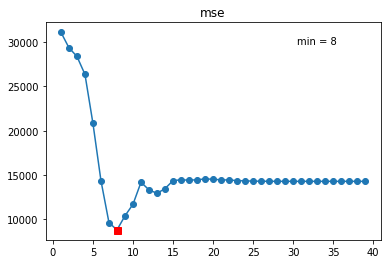

In [9]:
plt.figure()
plt.plot(np.arange(1,40),mses,'-o')
idx = np.argmin(mses)
plt.plot(np.arange(1,40)[idx],mses[idx],'sr',ms=7)
plt.title('mse')
ax = plt.gca()
plt.text(0.75,0.9,'min = ' + "{:d}".format(idx+1), transform=ax.transAxes);

**We have a minimum at 8, so we select a PLS regression model with 8 components.**

## 3. Using the model for predictions

Here, we are going to split up our dataset into testing and training datasets, with 30% of the dataset used for testing.

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#***************************************************************
# CHANGE the following line for the number of components:
pls = make_pipeline(preprocessing.StandardScaler(), 
                    PLSRegression(n_components=8))
pls.fit(X_train, y_train)

print('rmse = ' + '{:.3f}'.format(np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))) + 'g')
print('mae = ' + '{:.3f}'.format(mean_absolute_error(y_test, pls.predict(X_test))) + 'g')
print('r2 = ' + '{:.3f}'.format(pls.score(X_test,y_test)))

rmse = 84.882g
mae = 65.321g
r2 = 0.693


Plotting the results

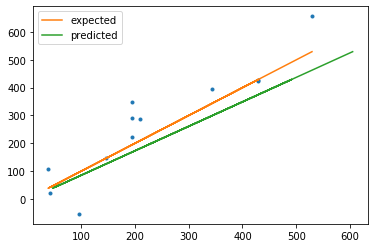

In [11]:
plt.plot(y_test, pls.predict(X_test),'.')
plt.plot(y_test,y_test,'-',label = 'expected')
z = np.polyfit(y_test, pls.predict(X_test),1)
plt.plot(np.polyval(z,y_test),y_test,'-',label='predicted')
plt.legend()

## Some extra plots

These are just a few plots of some of the data to see a bit more of what is going on

### The scaled reflectance data

Note - I have to transpose the data for it to plot correctly

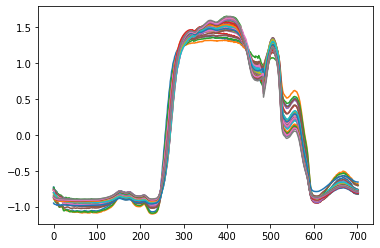

In [12]:
plt.plot(scale(X.T));

### The scaled training data

The training reflectance data from the dataset split for making predictions

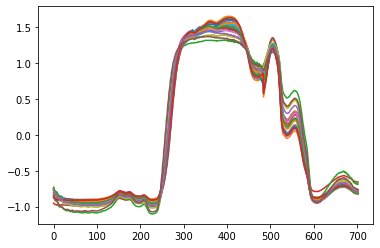

In [13]:
plt.plot(scale(X_train.T));

### The transformed training data

The training reflectance data from the dataset split for making predictions, transformed into it's PLS components

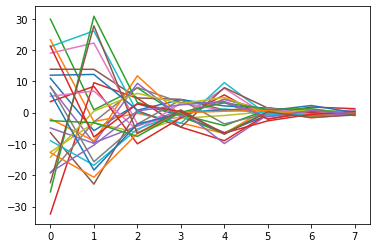

In [14]:
plt.plot(pls.transform(X_train).T);

### The model performance on the training data

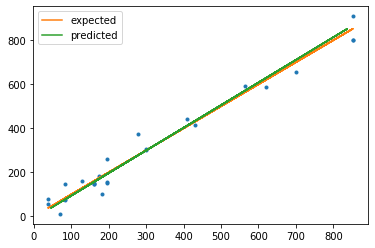

In [15]:
plt.plot(y_train, pls.predict(X_train),'.')
plt.plot(y_train,y_train,'-',label = 'expected')
z = np.polyfit(y_train, pls.predict(X_train),1)
plt.plot(np.polyval(z,y_train),y_train,'-',label='predicted')
plt.legend()

## Quick LOOCV test

rmse = 84.882g
mae = 65.321g
r2 = 0.693


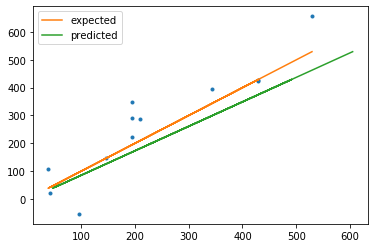

In [16]:
#define cross-validation method
cv = model_selection.LeaveOneOut()
    
#making pipeline
mses = []
for n_comps in np.arange(1,40):
    pls = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=n_comps))
    score = -1*model_selection.cross_val_score(pls, X, y, cv=cv, scoring = 'neg_mean_squared_error')
    val = score.mean()
    mses += [val]     

#finding number of components
idx = np.argmin(mses)+1

# predictions
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=0) 

#calculate RMSE
pls = make_pipeline(preprocessing.StandardScaler(), PLSRegression(n_components=idx))
pls.fit(X_train, y_train)

print('rmse = ' + '{:.3f}'.format(np.sqrt(mean_squared_error(y_test, pls.predict(X_test)))) + 'g')
print('mae = ' + '{:.3f}'.format(mean_absolute_error(y_test, pls.predict(X_test))) + 'g')
print('r2 = ' + '{:.3f}'.format(pls.score(X_test,y_test)))

plt.plot(y_test, pls.predict(X_test),'.')
plt.plot(y_test,y_test,'-',label = 'expected')
z = np.polyfit(y_test, pls.predict(X_test),1)
plt.plot(np.polyval(z,y_test),y_test,'-',label='predicted')
plt.legend()

This is the same as the K-fold method...